# Imports

In [9]:
# Usual stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Scipy
import scipy as sp
import scipy.sparse as spr

# Typing
from typing import Callable

# Hamiltonian

We construct a matrix for the following Hamiltonian:

$$
\begin{align*}

H^\text{MF} &= \sum_{\textbf k > 0} H_{\textbf k}

\end{align*}
$$

Where:

- $H_\textbf k$ couples only the $\pm\textbf k$ modes:
    
    $$
    \begin{align*}
    
    H_{\textbf k} &= \xi_\textbf k(\hat n_\textbf k + \hat n_{-\textbf k}) + U(\hat n_{\textbf k\uarr}\hat n_{\textbf k\darr} + \hat n_{-\textbf k\uarr}\hat n_{-\textbf k \darr})
    \\[0.2cm]
    
    &\quad +\Delta^*(b_\textbf k + b_{-\textbf k}) + \Delta(b_\textbf k^\dag + b_{-\textbf k}^\dag)
    
    \end{align*}
    $$
    
- $\Delta$ has to be solved self-consistently for:
    
    $$
    \begin{align*}
    
    \Delta &= -\frac{g}{L_d}\sum_\textbf k\lang b_\textbf k\rang
    
    \end{align*}
    $$

- $b_\textbf k$ is the pair operator for $s$-wave coupling:
    
    $$
    \begin{align*}
    
    b_\textbf k &= c_{-\textbf k\darr}c_{\textbf k\uarr}
    \\[0.2cm]

    b_\textbf k^\dag &= c_{\textbf k\uarr}^\dag c_{-\textbf k\darr}^\dag
    
    \end{align*}
    $$

We write the Hamiltonian in block-diagonal form, noticing that the number of particles pairs and the total spin are conserved, hence we get the following ten subspaces:
- **Parity of Particle Number**: Either $0$ or $1$.
- **Total Spin**: It is in the set $\pm4, \pm3, \pm2, \pm1, 0$.

## Helper Functions

In [10]:
def bissect(func: Callable, a: float, b: float, eps: float = 1e-6, maxI: int = 200, mult: bool = False) -> float:
    """
        Solves the equation `func(x) = 0` using the bissection method in [a, b].

        The function stops when the error is smaller then `eps` or the number of iterations exceeds `maxI`.

        The error is additive by default, but can be made multiplicative by setting `mult` = True

        ### Return
        x: The value of x that solves the equation.
    """

    # Evaluate on the edges
    fa, fb = func(a), func(b)

    # Check if there is a zero on the edges
    if abs(fa) <= 1e-16:
        return a
    elif abs(fb) <= 1e-16:
        return b

    # Main Loop
    i = 0
    error = (b-a)/2

    # For multiplicative error make sure to do at least one iteration
    if mult:
        error = eps + 1

    while abs(error) > eps:

        # Find the midpoint and evaluate the function there
        c = (a+b)/2
        fc = func(c)

        # Check if the zero is exactly on the midpoint
        if abs(fc) <= 1e-16:
            return c

        # Sign change happens in [a, c]
        elif fa * fc < 0:
            b = c
            fb = fc
        
        # Sign change happens in [c, b]
        elif fc * fb < 0:
            a = c
            fa = fc
        
        # No sign change
        else:
            raise ValueError(f"O sinal de f é o mesmo em a = {a} e em b = {b} (f(a) = {fa}, f(b) = {fb}) - iteração {i}).")

        # Compute the error
        error = (b - a)/2

        # If the error is multiplicative, compare the error with the midpoint value
        if mult:
            error /= (a+b)/2

        # Maximum number of iterations
        i += 1
        if i > maxI:
            raise ValueError(f"Não foi possível encontrar a raíz da função com a precisão desejada em menos de maxI = {maxI} iterações!")
        
    return (a+b)/2

In [11]:
def eps(kk: np.ndarray) -> np.ndarray:
    """
        Compute the dispersion relation for a given set of vectors `kk`.
    """
    return -2 * np.sum(np.cos(kk), axis = 0)


def fock(decimal: int, modes: int = 4) -> list[int]:
    return [(decimal >> n) % 2 for n in range(modes)][::-1]


# Sample code to convert from state to full fock space
# The four least significant bits (LSB) corresponds to k and the four MSBs corresponds to k+pi
state = 12
n_pk_u_i, n_pk_d_i, n_mk_u_i, n_mk_d_i = fock(state, 4)

We are using the basis:
$$
\begin{align*}
\ket{n_{k\uarr}, n_{k\darr}, n_{-k\uarr}, n_{-k\darr}}
\end{align*}
$$

## Subspaces

In [12]:
# CONSTANTS
MODES = 4
DIM = 2**MODES


# SUBSPACES
class Subspace:

    # Get properties and states
    # Technically we could even forget about the quantum numbers
    def __init__(self, parity: int, spin: int) -> None:
        # Quantum numbers of the subspace
        self.parity = parity
        self.spin = spin

        # States and dimension
        self.states = []
        self.dimension = 0
        self.Nk = 0

        # Lookup table
        self.lookup = dict()
    
    # Print
    def __str__(self) -> str:
        return f"Space with P = {self.parity} and S = {self.spin} contains {len(self.states)} states."

    
    # STATES
    
    # Add a state to the list
    def add_state(self, st: int) -> None:
        self.states += [st]

    # Build a lookup table {state: position} on the list
    def build_lookup(self) -> None:
        self.dimension = len(self.states)

        for index, st in enumerate(self.states):
            self.lookup[st] = index


    # OPERATORS

    # Create the operators
    def build_operators(self) -> tuple[np.ndarray, np.ndarray]:

        # Make sure we have a lookup table
        if len(self.lookup) == 0: self.build_lookup()

        # Operators (t for total, meaning both options)
        self.nk_tk_t = np.zeros((self.dimension, self.dimension), dtype=np.float64)

        self.nk_tk_d = np.zeros((self.dimension, self.dimension), dtype=np.float64)
        self.nk_tk_u = np.zeros((self.dimension, self.dimension), dtype=np.float64)
        
        self.bk_tk = np.zeros((self.dimension, self.dimension), dtype=np.float64)


        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_u, n_pk_d, n_mk_u, n_mk_d = st_list

            # Number of particles in the state
            self.nk_tk_t[ket, ket] = np.sum(st_list)

            # Number of particles with spin up and spin down
            self.nk_tk_u[ket, ket] = n_pk_u + n_mk_u
            self.nk_tk_d[ket, ket] = n_pk_d + n_mk_d

            # Applying bk to this state (st is the ket, we find the bra)
            # For the first line, the phase is (n_pk_u - 1) + n_pk_d + n_mk_u bu the first term is 0 because it is 1-1
            if n_mk_d * n_pk_u:
                bra_pk = self.lookup[st - 8 - 1]
                self.bk_tk[bra_pk, ket] += (-1)**(n_pk_d + n_mk_u)
            
            if n_pk_d * n_mk_u:
                bra_mk = self.lookup[st - 4 - 2]
                self.bk_tk[bra_mk, ket] += (-1)**(n_pk_d)
            
        return self.nk_tk_t, self.bk_tk
            
        
    # TODO: Change mesh_ee to mesh_xi (subtract before calling this function)
    def build_hamiltonian(self, Nk: int, mesh_xi: np.ndarray, U: float, Delta: complex) -> np.ndarray:

        # Number of k-points
        self.Nk = Nk

        # Hamiltonian
        self.ham = np.zeros((Nk, self.dimension, self.dimension), dtype=np.float64)

        # Diagonal
        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_u, n_pk_d, n_mk_u, n_mk_d = st_list

            # Kinetic Energy
            self.ham[:, ket, ket] += mesh_xi * np.sum(n_pk_u + n_pk_d + n_mk_u + n_mk_d)

            # HK Interaction
            self.ham[:, ket, ket] += U * (n_pk_u * n_pk_d + n_mk_u * n_mk_d)

        # Off-diagonal

        # SC Interaction
        self.ham += np.conjugate(Delta) * self.bk_tk
        self.ham += Delta * np.transpose(self.bk_tk)

        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(f"The space is (P, S) = ({self.parity}, {self.spin})")

        return self.ham



def generate_fspace() -> dict[tuple[int, int], Subspace]:
    """
        Generate the Fock space for our problem.
    """

    # Create all spaces (types so we can have hints)
    fspace = dict[tuple[int, int], Subspace]()
    for parity in [0, 1]:
        for spin in range(-MODES//2, MODES//2+1):
            # If we have an even number of particles then spin must be even
            if abs(spin) % 2 == parity:
                fspace[(parity, spin)] = Subspace(parity, spin)


    # STATES
    for st in range(DIM):

        # Compute parity
        parity = np.sum([(st >> n) % 2 for n in range(MODES)]) % 2

        # Compute spin
        spin = np.sum([(st >> (2*n + 1)) % 2 for n in range(MODES//2)]) - np.sum([(st >> (2*n)) % 2 for n in range(MODES//2)])

        # Add state to correct subspace
        fspace[(parity, spin)].add_state(st)


    # Build lookup tables
    # Check size of spaces, and that they add to the whole space
    maxi = 0
    total = 0
    for key in fspace:
        fspace[key].build_lookup()
        maxi = np.max([maxi, len(fspace[key].states)])
        total += len(fspace[key].states)

        # print(key, len(fspace[key].states))
        
    # print(f"Is the total number of states {DIM}? {"Yes" if total == DIM else "No"}")
    # print(f"The biggest space has {maxi} states.")

    return fspace

## Thermal Average

In [13]:
def thermal_average(fspace: dict[tuple[int, int], Subspace], eigen: dict[tuple[int, int], tuple[np.ndarray, np.ndarray]], opcode: str, T: float, E0: np.ndarray, mult_kk: np.ndarray = np.array([]), make_positive: bool = False) -> float:

    # Number of k-points
    Nk = fspace[(0, 0)].Nk

    # Partition function
    Z = np.zeros(Nk)

    # Boltzmann weights
    bb = dict()


    for key in fspace:
        # Get eigenvalues and eigenvecs
        vals, _ = eigen[key]

        # Minimum energy, to scale Boltzmann factors
        valsE0 = vals - E0[:, None]

        # Boltzmann exponential
        bexp = np.exp(-valsE0/T)
        bb[key] = bexp

        # Compute partition function (sum over all dim states for each k)
        Z += np.sum(bexp, axis = 1)

    # Compute Boltzmann factor
    for key in eigen:

        # Divide by partition function
        bb[key] /= Z[:, None]
    
    # Compute average via a trace
    res = 0
    for key in fspace:
        
        # Get eigenvalues and eigenvecs
        vals, vecs = eigen[key]
        
        # Choose operator
        op = getattr(fspace[key], opcode)
        
        # Choose Boltzman factor
        bfac = bb[key]

        # Operator times the kets
        temp = op @ vecs
        
        # Bra times (op |ket>) via expectation[k, i] = sum_j conj(vecs[k, j, i]) * temp[k, j, i]
        expectation = np.einsum("kji,kji->ki", vecs.conj(), temp)

        if make_positive:
            expectation = np.abs(expectation)

        # Sum over i with Boltzmann factor
        res_kk = np.sum(bfac * expectation, axis=1)

        if len(mult_kk) == 0:
            # Sum over k
            res += np.sum(res_kk)
        
        else:
            # Sum over k with the factor mult for each k-point
            res += np.sum(res_kk * mult_kk)

    return res

## Solving the Hamiltonian

In [14]:
def solve(L: int, d: int, mu: float, U: float, g: float, T: float, delta_start: float = 1e-2, delta_eps: float = 1e-4):
    """
        Solve the mean-field Hamiltonian for `L` k-points along each `d` directions for temperature `T` and chemical potential `mu`.

        Self-consistently compute Delta starting at `delta_start` with an error of `delta_eps`.
    """

    # Possible adjustments
    # Take out the [:-1] from kk
    # Change the kx > 0 into kx >= 0


    # OBTAINING K-POINTS

    # Determine values of k in our lattice
    kk = np.linspace(-np.pi, np.pi, L + 1)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (d, L ** d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d)

    # Select only 0 < kx
    mesh_kk = mesh_kk[:, (0 < mesh_kk[0])]

    # Compute corresponding energies
    mesh_ee = eps(mesh_kk)

    # Compute dispersion relation
    mesh_xi = mesh_ee - mu

    # Number of k-points
    Nk = len(mesh_kk[0])


    # SET UP FOCK SPACE

    # Generate the space
    fspace = generate_fspace()

    # Prepare the subspaces
    for key in fspace:
        fspace[key].build_operators()


    # SELF-CONSISTENT CALCULATION OF DELTA
    if g == 0:
        delta_start = 0
    else:
        delta_error = delta_eps + 1
        while delta_error > delta_eps:
            
            # Solve the Hamiltonian
            E0 = np.zeros(Nk) + 1e6
            eigen = dict()
            for key in fspace:

                # Generate Hamiltonian
                ham = fspace[key].build_hamiltonian(Nk, mesh_xi, U, delta_start)

                # Diagonalize Hamiltonians
                vals, vecs = np.linalg.eigh(ham)

                # Save the results
                eigen[key] = (vals, vecs)
            
                # Compute minimum energy for each k-point
                E0 = np.minimum(E0, np.min(vals, axis=1))
                
            # Compute the component of delta for this subspace
            delta_new = thermal_average(fspace, eigen, "bk_tk", T, E0)
            
            delta_new *= -g / (2 * Nk)

            # Compute error
            delta_error = np.abs(delta_start - delta_new)

            # Prepare next loop
            delta_start = delta_new
    

    # SOLVE FOR CONVERGED DELTA

    E0 = np.zeros(Nk) + 1e6
    eigen = dict()
    for key in fspace:

        # Generate Hamiltonian
        ham = fspace[key].build_hamiltonian(Nk, mesh_xi, U, delta_start)
        
        # Diagonalize Hamiltonians
        vals, vecs = np.linalg.eigh(ham)

        
        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(f"The space is (P, S) = ({fspace[key].parity}, {fspace[key].spin})")
        #     print(f"States are {fspace[key].states}")
        #     print(vals)
        #     print(vecs)

        # Save the results
        eigen[key] = (vals, vecs)
    
        # Compute minimum energy for each k-point
        E0 = np.minimum(E0, np.min(vals, axis=1))


    # Compute expectation values
    delta = thermal_average(fspace, eigen, "bk_tk", T, E0)
    n = thermal_average(fspace, eigen, "nk_tk_t", T, E0)
    Kxx = thermal_average(fspace, eigen, "nk_tk_t", T, E0, mult_kk=-mesh_ee)


    # Normalize
    delta *= -g / (2 * Nk)
    n *= 1 / (2 * Nk)

    # Here the normalization is 4*Nk because L**d = 4*Nk as we take kx > 0 in the beggining
    Kxx *= np.pi / (4 * Nk)

    return np.abs(delta), n, Kxx

In [15]:
# PARAMETERS
L = 100
d = 1
U = 1
mu = 0.5
g = 1.5
T = 0.01

# Example CALCULATION
Delta, n, Kxx = solve(L, d, mu, U, g, T)

## Computing $T_c$

### Via Bissection 

 Obtained Tc = 0.09942031250000001 for mu = 1.6 (Progress 21/21)Progress 20/21)

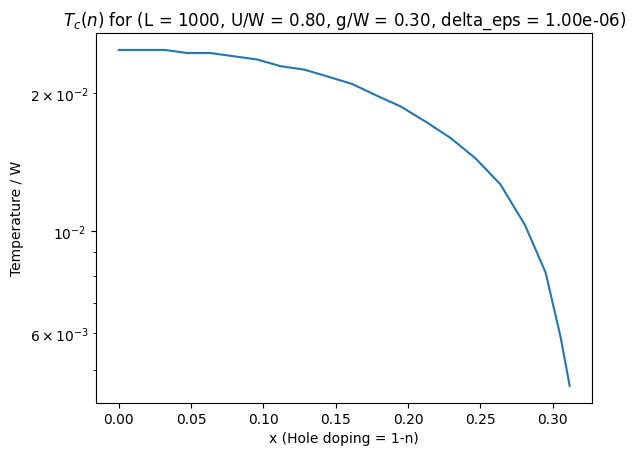

In [16]:
# CONSTANTS
d = 1
W = 4 * d

# PARAMETERS
# L = 500
g = 0.3 * W
U = 0.8 * W

# Range of mu to compute
mu_min = U/2 - 0.5
mu_max = U/2 + 0.0
mu_steps = 21

mm = np.linspace(mu_min, mu_max, mu_steps)

# Range of T to study
tt_min = 1e-4 * W
tt_max = 5e-2 * W

# Thresholds for delta
delta_zero = 1e-5
delta_start = 1e-2
delta_eps = 1e-6

# Multiplicative bissection error for Tc
biss_eps = 0.01


# CALCULATION
for L in [1000]:

    # Find Tc(mu)
    tt = []
    for index, mu in enumerate(mm):
        Tc = bissect(lambda T: solve(L, d, mu, U, g, T, delta_start=delta_start, delta_eps=delta_eps)[0] - delta_zero, tt_min, tt_max, eps=biss_eps, mult=True)
        tt += [Tc]

        print(f"\r Obtained Tc = {Tc} for mu = {mu} (Progress {index + 1}/{len(mm)})", end="")


    # Find Tc(n)
    nn = []
    for index in range(len(mm)):
        mu, T = mm[index], tt[index]
        delta, n, _ = solve(L, d, mu, U, g, T, delta_start=delta_start, delta_eps=delta_eps)

        nn += [n]

    # Pass to array
    tt = np.array(tt)
    nn = np.array(nn)

    plt.title(f"$T_c(n)$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f}, delta_eps = {delta_eps:.2e})")
    plt.plot(1 - nn, tt / W)
    plt.xlabel("x (Hole doping = 1-n)")
    plt.ylabel("Temperature / W")
    plt.yscale("log")
    plt.show()

### Via Threshold

In [17]:
# # CONSTANTS
# d = 1
# W = 4

# # PARAMETERS
# L = 500
# g = 0.1 * W
# U = 0.6 * W

# # Range of mu to compute
# mu_min = U/2 - 0.5
# mu_max = U/2 + 0.5
# mu_steps = 11

# mm = np.linspace(mu_min, mu_max, mu_steps)

# # Range of T to study
# tt_min = 1e-6 * W
# tt_max = 5e-3 * W
# tt_steps = 20
# tt = np.exp(np.linspace(np.log(tt_min), np.log(tt_max), tt_steps))

# # Threshold for delta (error is 0.01 times this)
# delta_zero = 1e-4
# delta_start = 1e-2
# delta_eps = 1e-6

# # CALCULATION
# cc = []
# nn = []
# for mu in mm:
#     nn_temp = []
#     dd = []
#     for T in tt:
#         delta, n, afm, fm, Kx = solve(L, d, mu, U, g, T, delta_start=delta_start, delta_eps=delta_eps)
#         nn_temp += [n]
#         dd += [delta]

#     # Pass to array
#     nn_temp = np.array(nn_temp)
#     dd = np.array(dd)

#     plt.plot(tt/W, dd, label=f"x = {1-np.average(nn_temp):.3f} $\\pm$ {np.std(nn_temp):.2e}")

#     plt.title(f"$\\Delta$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f})")
#     plt.xlabel("Temperature / W")
#     plt.xscale("log")
#     plt.ylabel("$\\Delta$")
#     plt.legend(bbox_to_anchor=(1.3, 1.0))
#     plt.show()
    
#     # Find Tc as the maximum temperature where Delta > delta_zero
#     Tc = np.max(tt[dd > delta_zero])
#     cc += [Tc]

#     # # Find Tc as the point with biggest derivative dDelta/dT
#     # dDdT = np.abs((dd[1:] - dd[:-1]) / (tt[1:] - tt[:-1]))
#     # index = list(dDdT).index(np.max(dDdT))
#     # Tc = (tt[index] + tt[index + 1]) / 2
#     # cc += [Tc]

#     # Compute n for Tc
#     delta, n, afm, fm, Kx = solve(L, d, mu, U, g, T, delta_start=delta_start, delta_eps=delta_eps)
#     nn += [n]

# # Pass to array
# nn = np.array(nn)
# cc = np.array(cc)

# print(nn)

# plt.title(f"$T_c(n)$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f})")
# plt.plot(1 - nn, cc / W)
# plt.xlabel("x (Hole doping = 1-n)")
# plt.ylabel("Temperature / W")
# plt.yscale("log")
# plt.show()

## Conductivity

## Superfluid Stifness


Done U = 0.0 and g = 0.0

Done U = 0.0 and g = 3.0

Done U = 12.0 and g = 0.0

Done U = 12.0 and g = 3.0


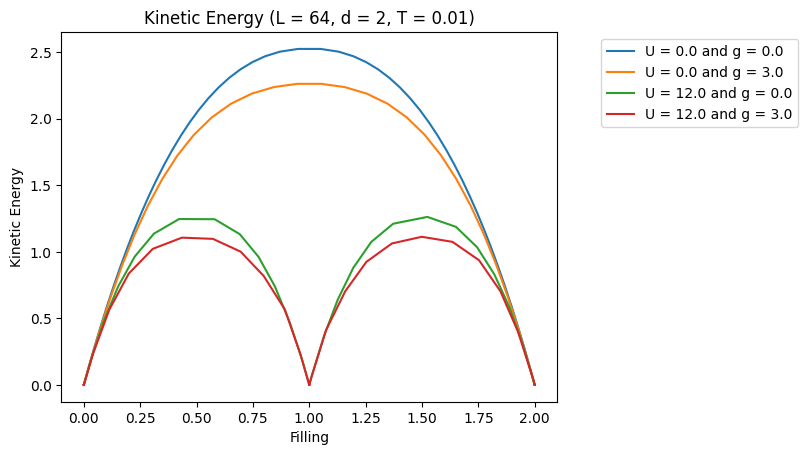

In [18]:
# CONSTANTS
d = 2
W = 4

# PARAMETERS
L = 64
T = 0.01


# g SWEEP
gg = [0.0, 3.0]

# U SWEEP
uu = [0.0, 12.0]

# Calculations
for U in uu:
    for g in gg:

        # Range of mu to compute
        mu_min = -2*d - U - g
        mu_max = -mu_min
        mu_steps = 50

        mm = np.linspace(mu_min, mu_max, mu_steps)

        nn = []
        ss = []
        for index, mu in enumerate(mm):

            # Solve the Hamiltonian
            Delta, n, Kxx = solve(L, d, mu, U, g, T)

            # Save the filling
            nn += [n]

            # Save the superfluid stifness
            ss += [Kxx]

            # Show progress
            # print(f"\rProgress: {index + 1}/{len(mm)}", end="")
        
        print("")
        print(f"Done U = {U} and g = {g}")
            
        plt.plot(nn, ss, label=f"U = {U} and g = {g}")

plt.title(f"Kinetic Energy (L = {L}, d = {d}, T = {T})")
plt.xlabel("Filling")
plt.ylabel("Kinetic Energy")
plt.legend(bbox_to_anchor=(1.5, 1.))

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

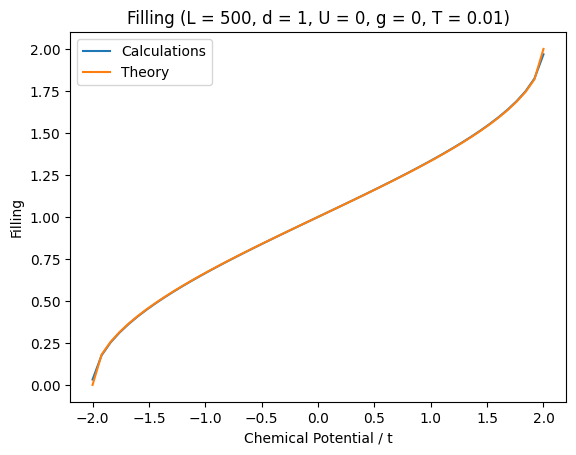

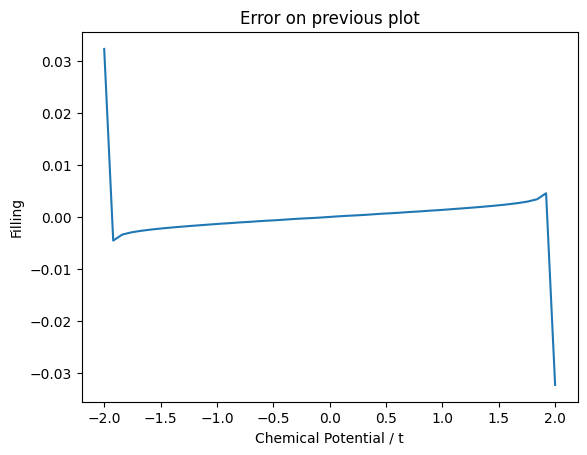

In [19]:
# PARAMETERS
L = 500
d = 1
U = 0
g = 0
T = 0.01


# MU SWEEP
mu_start = -2*d - U
mu_end = -mu_start
mu_steps = int(L/10)


# Calculations
mm = np.linspace(mu_start, mu_end, mu_steps+1)
nn = []
for mu in mm:

    # Solve the Hamiltonian
    Delta, n, Kxx = solve(L, d, mu, U, g, T)

    # Save the filling
    nn += [n]

nn_theory = (2 / np.pi) * np.arccos(-0.5 * mm)

plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, T = {T})")
plt.ylabel("Filling")
plt.xlabel("Chemical Potential / t")
plt.plot(mm, nn, label="Calculations")
plt.plot(mm, nn_theory, label="Theory")
plt.legend()
plt.show()

plt.title("Error on previous plot")
plt.plot(mm, nn - nn_theory)
plt.ylabel("Filling")
plt.xlabel("Chemical Potential / t")
plt.show()